Using device: cpu
Classes: ['cherry', 'strawberry', 'tomato']
Number of images: 4485


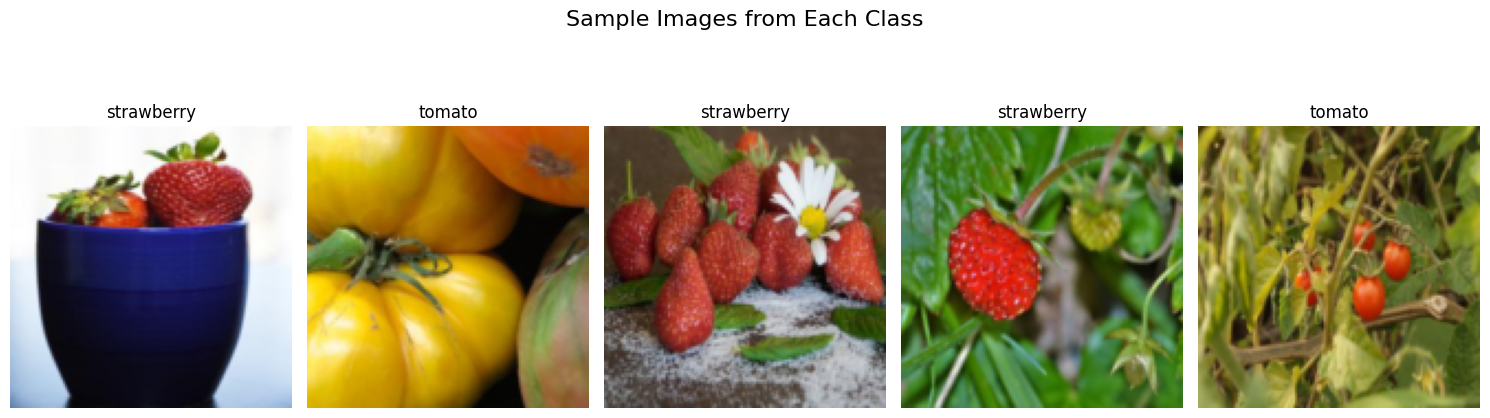

In [4]:
import os
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from skimage.color import rgb2gray
from skimage.filters import try_all_threshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.feature import graycomatrix, graycoprops

# Set device
device = torch.device('cpu')
print("Using device:", device)

# Define data directory and classes
data_dir = "train_data"
classes = ['cherry', 'tomato', 'strawberry']

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load dataset
dataset = ImageFolder(root=data_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get class names
class_names = dataset.classes
print("Classes:", class_names)
print("Number of images:", len(dataset))

# Function to display images
def show_images(images, labels, class_names, title="Sample Images"):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, image in enumerate(images):
        ax = axes[idx]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(class_names[labels[idx]], fontsize=12)
        ax.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Get a batch of images
data_iter = iter(data_loader)
images, labels = next(data_iter)
images = images[:5]
labels = labels[:5]

# Show sample images
show_images(images, labels, class_names, title="Sample Images from Each Class")


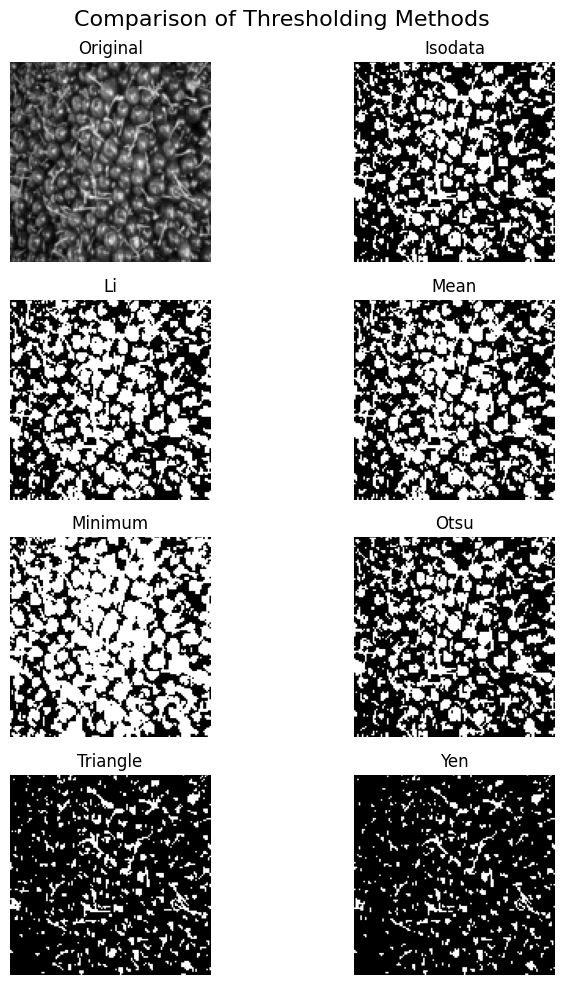

In [5]:
from skimage.color import rgb2gray
from skimage.filters import try_all_threshold

sample_image, _ = dataset[0]
sample_image_np = sample_image.permute(1, 2, 0).numpy()  

sample_image_np = (sample_image_np * 255).astype(np.uint8)

gray_image = rgb2gray(sample_image_np)

fig, ax = try_all_threshold(gray_image, figsize=(12, 10), verbose=False)
plt.suptitle('Comparison of Thresholding Methods', fontsize=16)
plt.tight_layout()
plt.show()


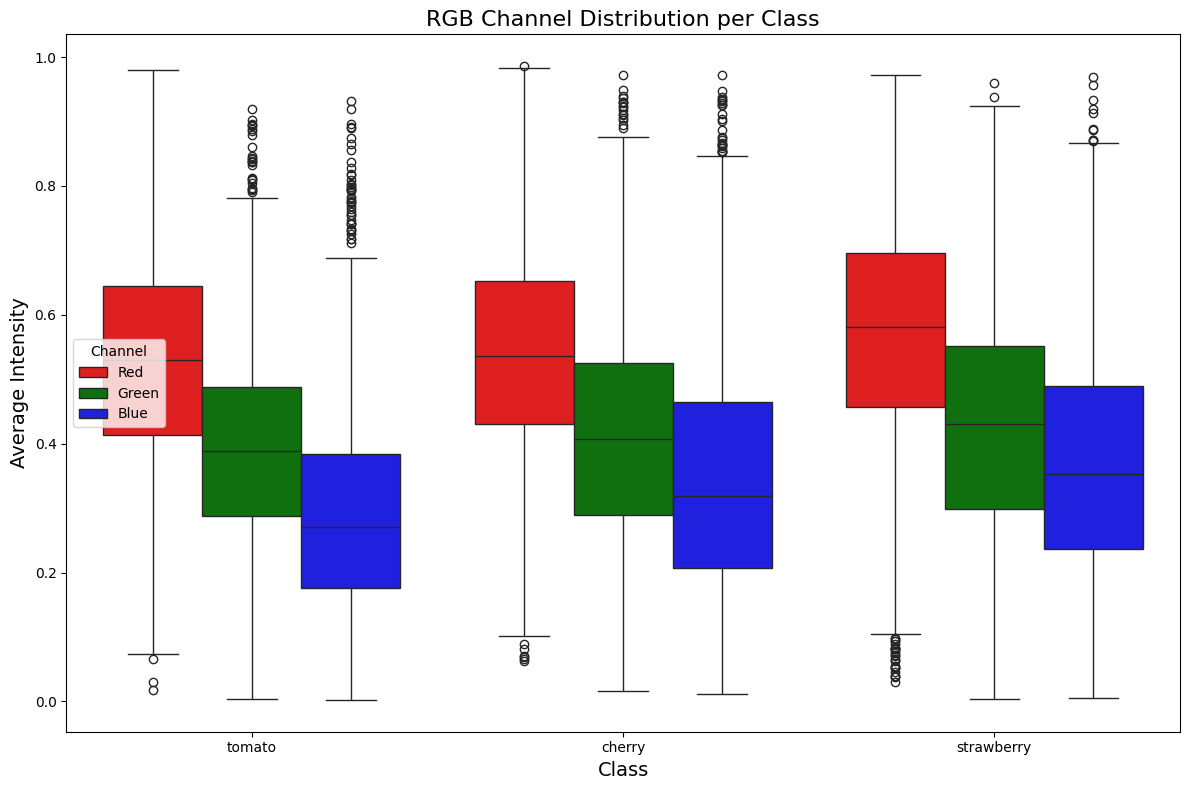

In [6]:
# Import additional libraries
import pandas as pd
import seaborn as sns

# Prepare data for DataFrame
data = {
    'Class': [],
    'Red': [],
    'Green': [],
    'Blue': []
}

# Prepare class_data dictionary
class_data = {class_name: [] for class_name in class_names}

# Loop through the dataset to populate the data dictionary
for images, labels in data_loader:
    for i, label in enumerate(labels):
        class_name = class_names[label]
        image = images[i]
        
        # Store images for future use
        class_data[class_name].append(image)
        
        # Calculate mean RGB for each image
        red_mean = image[0].mean().item()
        green_mean = image[1].mean().item()
        blue_mean = image[2].mean().item()
        
        # Append to the data dictionary
        data['Class'].append(class_name)
        data['Red'].append(red_mean)
        data['Green'].append(green_mean)
        data['Blue'].append(blue_mean)

# Create DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for seaborn boxplot
df_melted = df.melt(id_vars=['Class'], value_vars=['Red', 'Green', 'Blue'], var_name='Channel', value_name='Intensity')

# Plot the boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_melted, x='Class', y='Intensity', hue='Channel', palette=['red', 'green', 'blue'])
plt.xlabel('Class', fontsize=14)
plt.ylabel('Average Intensity', fontsize=14)
plt.title('RGB Channel Distribution per Class', fontsize=16)
plt.legend(title='Channel')
plt.tight_layout()
plt.show()


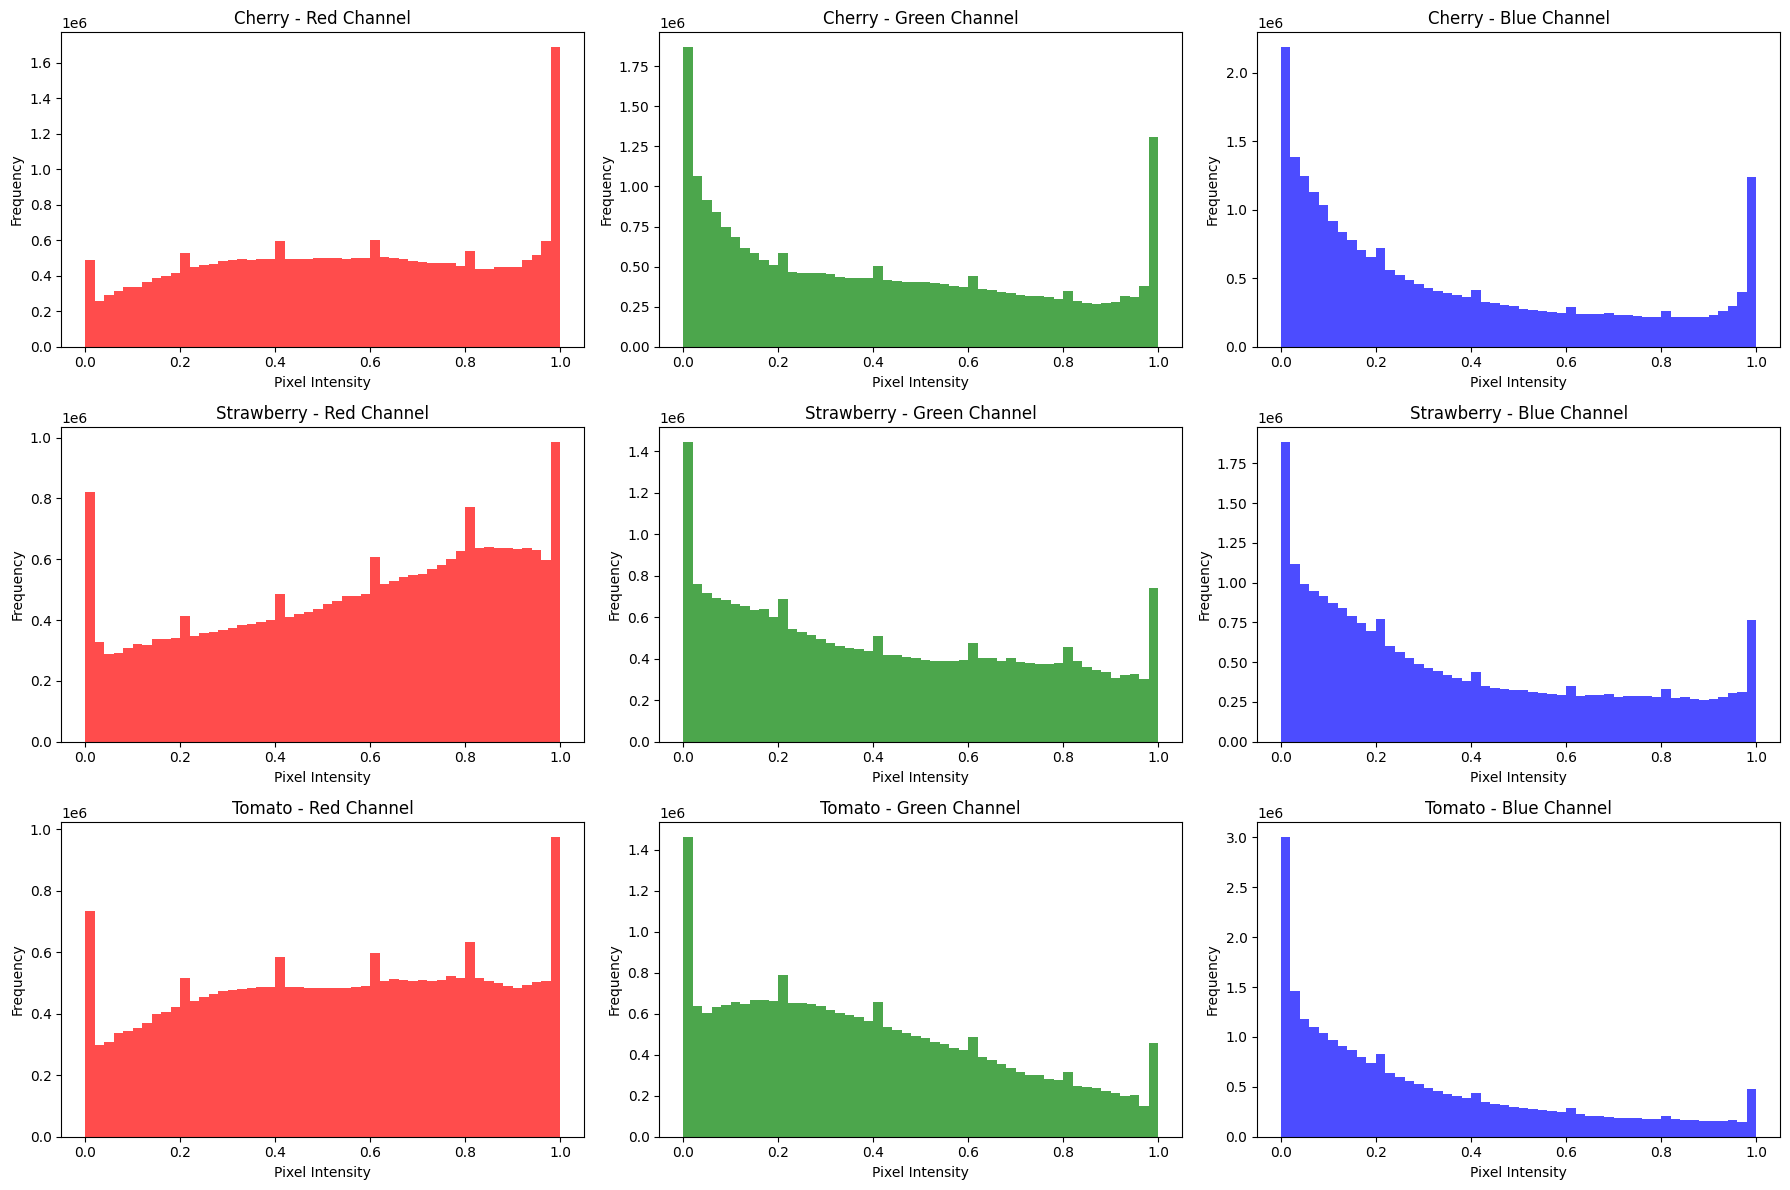

In [7]:
# Plot histograms of pixel intensities per class
fig, axes = plt.subplots(len(class_names), 3, figsize=(18, 12))

for idx, class_name in enumerate(class_names):
    images = torch.stack(class_data[class_name], dim=0)
    # Flatten the pixels for each channel
    red_pixels = images[:, 0, :, :].flatten().numpy()
    green_pixels = images[:, 1, :, :].flatten().numpy()
    blue_pixels = images[:, 2, :, :].flatten().numpy()
    
    axes[idx, 0].hist(red_pixels, bins=50, color='red', alpha=0.7)
    axes[idx, 0].set_title(f"{class_name.capitalize()} - Red Channel", fontsize=12)
    axes[idx, 1].hist(green_pixels, bins=50, color='green', alpha=0.7)
    axes[idx, 1].set_title(f"{class_name.capitalize()} - Green Channel", fontsize=12)
    axes[idx, 2].hist(blue_pixels, bins=50, color='blue', alpha=0.7)
    axes[idx, 2].set_title(f"{class_name.capitalize()} - Blue Channel", fontsize=12)

for ax in axes.flat:
    ax.set_xlabel('Pixel Intensity', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.show()


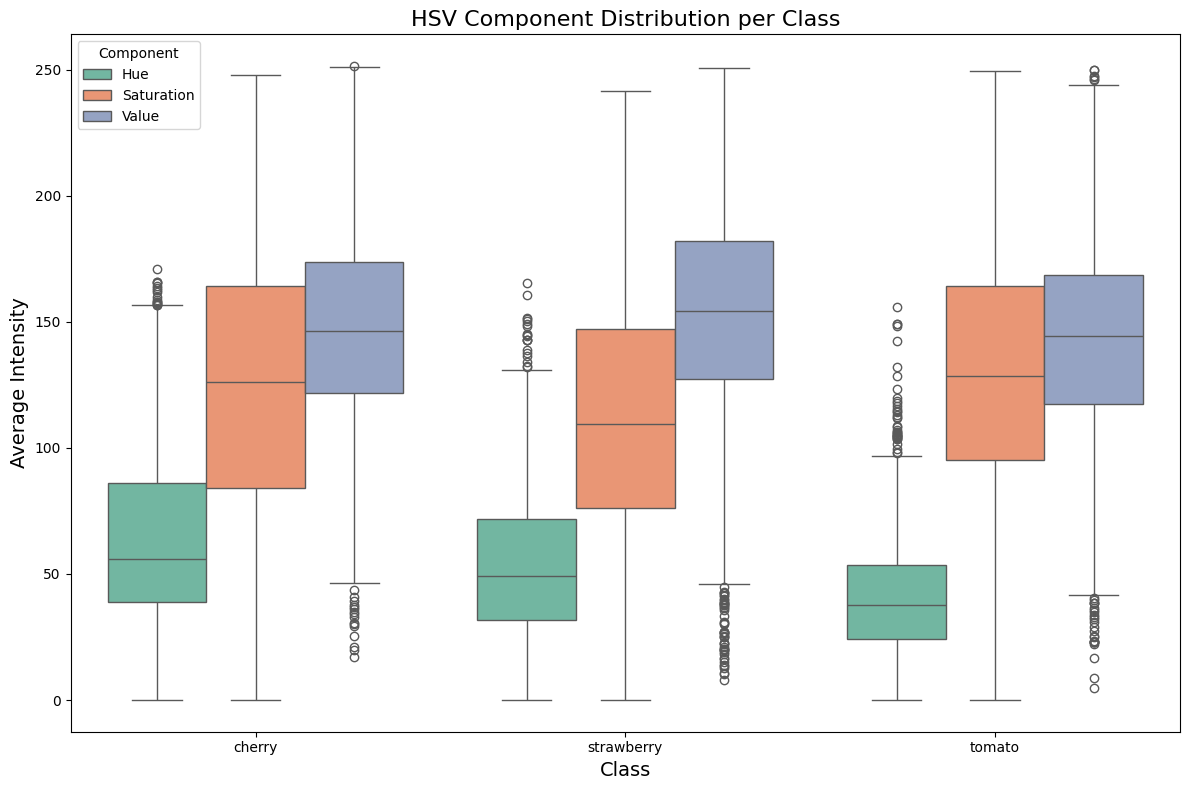

In [8]:
import cv2

# Prepare data for HSV analysis
hsv_data = {
    'Class': [],
    'Hue': [],
    'Saturation': [],
    'Value': []
}

# Loop through the dataset to populate the data dictionary
for images, labels in data_loader:
    for i, label in enumerate(labels):
        class_name = class_names[label]
        image = images[i]
        
        # Convert tensor to numpy array and transpose to HWC format
        image_np = image.permute(1, 2, 0).numpy()
        image_np = (image_np * 255).astype(np.uint8)
        
        # Convert RGB to HSV
        hsv_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
        
        # Calculate mean HSV values
        h_mean = hsv_image[:, :, 0].mean()
        s_mean = hsv_image[:, :, 1].mean()
        v_mean = hsv_image[:, :, 2].mean()
        
        # Append to the data dictionary
        hsv_data['Class'].append(class_name)
        hsv_data['Hue'].append(h_mean)
        hsv_data['Saturation'].append(s_mean)
        hsv_data['Value'].append(v_mean)

# Create DataFrame
hsv_df = pd.DataFrame(hsv_data)

# Melt the DataFrame for seaborn boxplot
hsv_df_melted = hsv_df.melt(id_vars=['Class'], value_vars=['Hue', 'Saturation', 'Value'],
                            var_name='Component', value_name='Intensity')

# Plot the boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(data=hsv_df_melted, x='Class', y='Intensity', hue='Component', palette='Set2')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Average Intensity', fontsize=14)
plt.title('HSV Component Distribution per Class', fontsize=16)
plt.legend(title='Component')
plt.tight_layout()
plt.show()


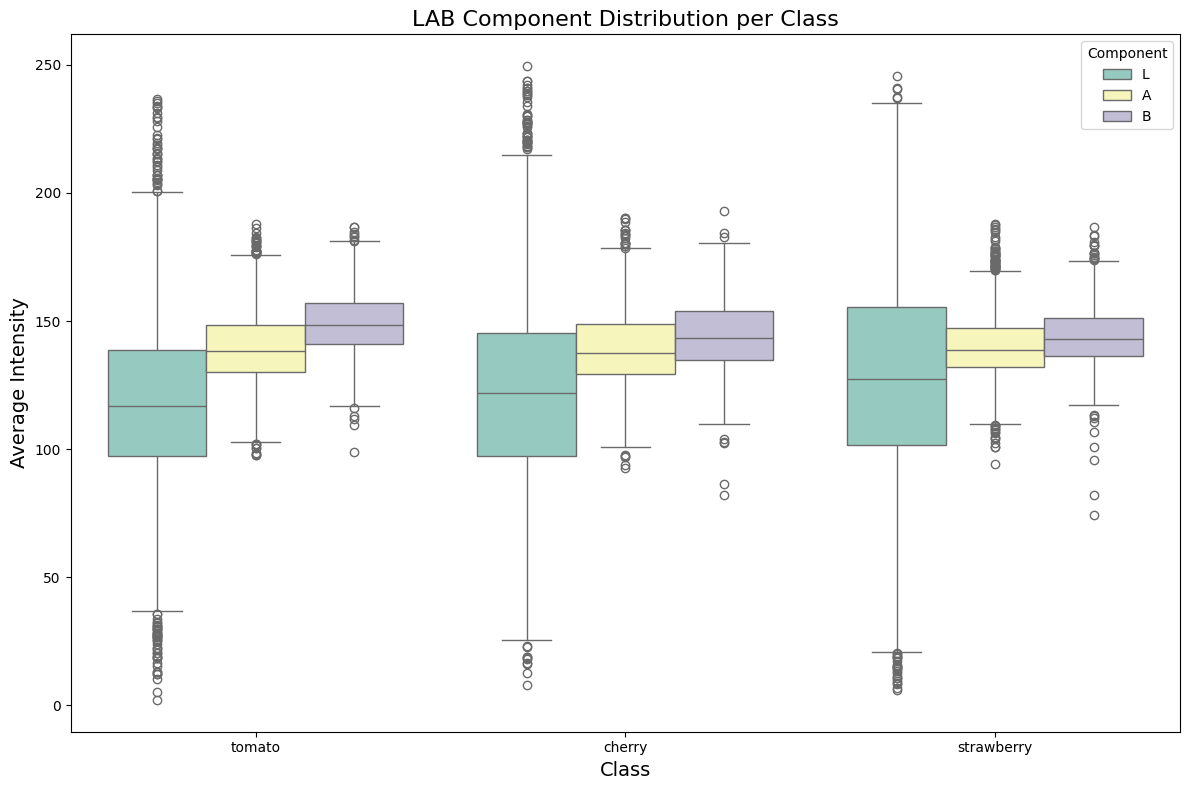

In [9]:
# Prepare data for LAB analysis
lab_data = {
    'Class': [],
    'L': [],
    'A': [],
    'B': []
}

# Loop through the dataset to populate the data dictionary
for images, labels in data_loader:
    for i, label in enumerate(labels):
        class_name = class_names[label]
        image = images[i]
        
        # Convert tensor to numpy array and transpose to HWC format
        image_np = image.permute(1, 2, 0).numpy()
        image_np = (image_np * 255).astype(np.uint8)
        
        # Convert RGB to LAB
        lab_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        
        # Calculate mean LAB values
        l_mean = lab_image[:, :, 0].mean()
        a_mean = lab_image[:, :, 1].mean()
        b_mean = lab_image[:, :, 2].mean()
        
        # Append to the data dictionary
        lab_data['Class'].append(class_name)
        lab_data['L'].append(l_mean)
        lab_data['A'].append(a_mean)
        lab_data['B'].append(b_mean)

# Create DataFrame
lab_df = pd.DataFrame(lab_data)

# Melt the DataFrame for seaborn boxplot
lab_df_melted = lab_df.melt(id_vars=['Class'], value_vars=['L', 'A', 'B'],
                            var_name='Component', value_name='Intensity')

# Plot the boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(data=lab_df_melted, x='Class', y='Intensity', hue='Component', palette='Set3')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Average Intensity', fontsize=14)
plt.title('LAB Component Distribution per Class', fontsize=16)
plt.legend(title='Component')
plt.tight_layout()
plt.show()


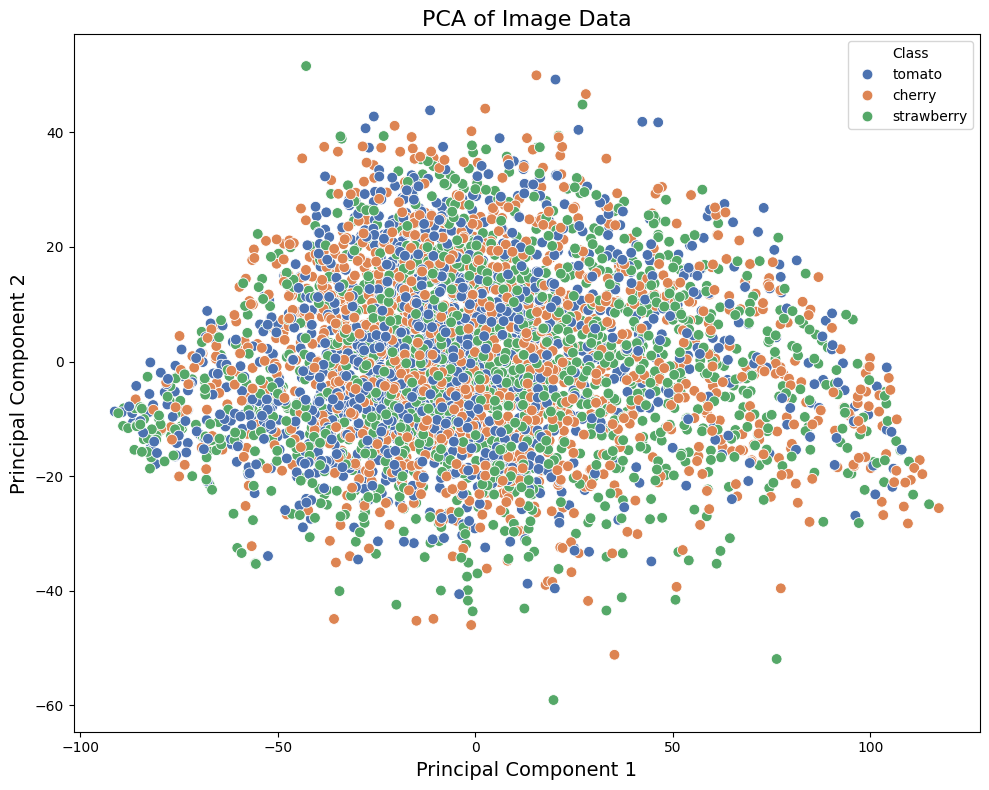

In [10]:
from sklearn.decomposition import PCA

# Prepare data for PCA
all_images = []
all_labels = []

for images, labels in data_loader:
    for i in range(len(labels)):
        image = images[i].flatten().numpy()
        all_images.append(image)
        all_labels.append(class_names[labels[i]])

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(all_images)

# Create DataFrame for plotting
pca_df = pd.DataFrame(data={
    'PC1': principal_components[:, 0],
    'PC2': principal_components[:, 1],
    'Class': all_labels
})

# Plot the PCA result
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Class', palette='deep', s=60)
plt.title('PCA of Image Data', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Class')
plt.tight_layout()
plt.show()


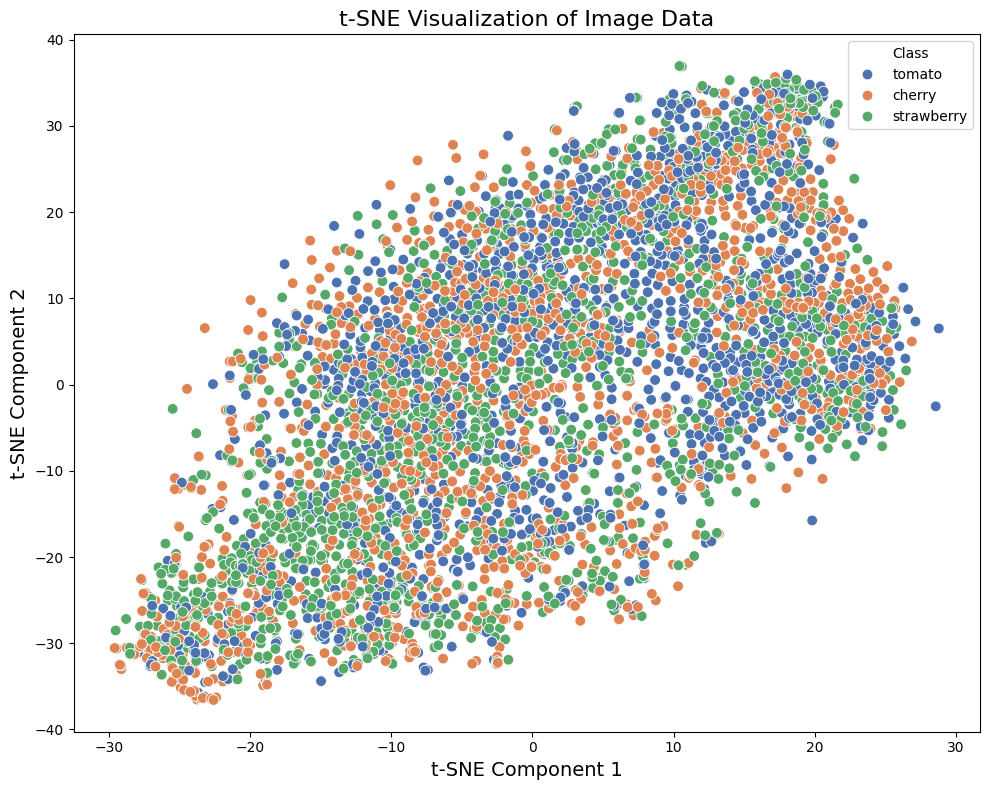

In [11]:
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(all_images)

# Create DataFrame for plotting
tsne_df = pd.DataFrame(data={
    'TSNE1': tsne_components[:, 0],
    'TSNE2': tsne_components[:, 1],
    'Class': all_labels
})

# Plot the t-SNE result
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Class', palette='deep', s=60)
plt.title('t-SNE Visualization of Image Data', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.legend(title='Class')
plt.tight_layout()
plt.show()


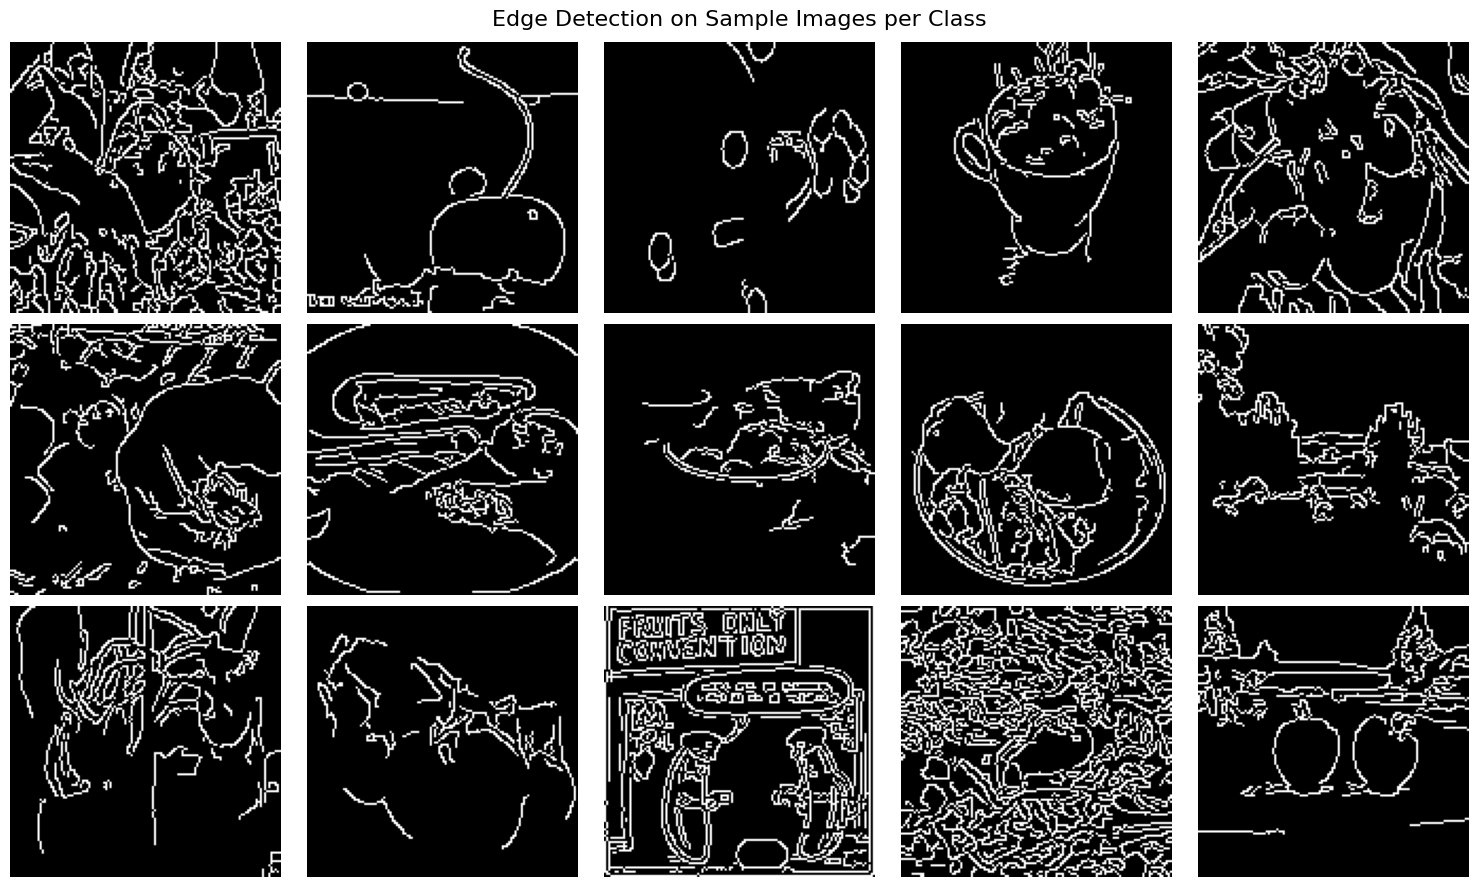

In [12]:
# Function to perform edge detection
def edge_detection(image):
    image_np = image.permute(1, 2, 0).numpy()
    image_gray = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(image_gray, threshold1=100, threshold2=200)
    return edges

# Plot edge-detected images
fig, axes = plt.subplots(len(class_names), 5, figsize=(15, 9))
for idx, class_name in enumerate(class_names):
    images = class_data[class_name][:5]  # Get first 5 images of each class
    for jdx, image in enumerate(images):
        edges = edge_detection(image)
        ax = axes[idx, jdx]
        ax.imshow(edges, cmap='gray')
        if jdx == 0:
            ax.set_ylabel(class_name.capitalize(), fontsize=14)
        ax.axis('off')

plt.suptitle('Edge Detection on Sample Images per Class', fontsize=16)
plt.tight_layout()
plt.show()


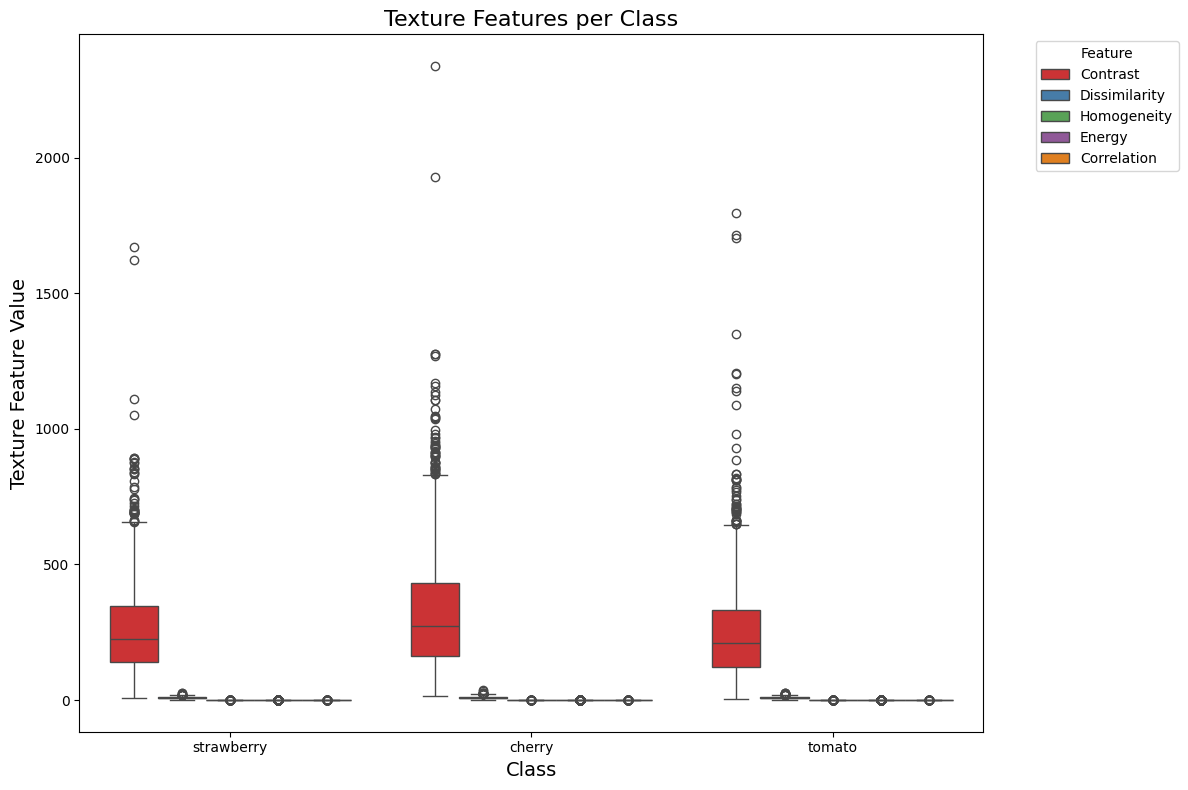

In [13]:
from skimage.feature import graycomatrix, graycoprops

# Prepare data for texture analysis
texture_data = {
    'Class': [],
    'Contrast': [],
    'Dissimilarity': [],
    'Homogeneity': [],
    'Energy': [],
    'Correlation': []
}

# Parameters for GLCM
distances = [1]
angles = [0]

# Loop through the dataset to compute texture features
for images, labels in data_loader:
    for i, label in enumerate(labels):
        class_name = class_names[label]
        image = images[i]
        
        # Convert to grayscale
        image_np = image.permute(1, 2, 0).numpy()
        image_gray = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        
        # Compute GLCM
        glcm = graycomatrix(image_gray, distances=distances, angles=angles, symmetric=True, normed=True)
        
        # Compute texture properties
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        
        # Append to the data dictionary
        texture_data['Class'].append(class_name)
        texture_data['Contrast'].append(contrast)
        texture_data['Dissimilarity'].append(dissimilarity)
        texture_data['Homogeneity'].append(homogeneity)
        texture_data['Energy'].append(energy)
        texture_data['Correlation'].append(correlation)

# Create DataFrame
texture_df = pd.DataFrame(texture_data)

# Melt the DataFrame for seaborn boxplot
texture_df_melted = texture_df.melt(id_vars=['Class'], var_name='Feature', value_name='Value')

# Plot the boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(data=texture_df_melted, x='Class', y='Value', hue='Feature', palette='Set1')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Texture Feature Value', fontsize=14)
plt.title('Texture Features per Class', fontsize=16)
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


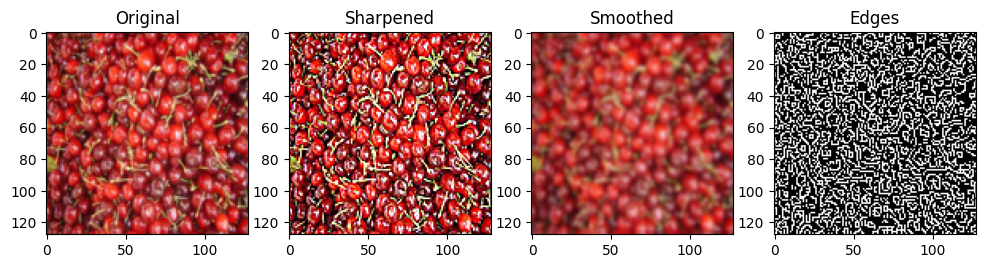

In [14]:
import cv2
from torchvision.transforms.functional import to_pil_image

sample_image, _ = dataset[0]
sample_image_np = sample_image.permute(1, 2, 0).numpy()  # Convert to HWC format for OpenCV

# Convert to uint8 for OpenCV processing
sample_image_np = (sample_image_np * 255).astype(np.uint8)

# Sharpening filter
sharpening_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened = cv2.filter2D(sample_image_np, -1, sharpening_kernel)

# Smoothing filter
smoothed = cv2.GaussianBlur(sample_image_np, (5, 5), 0)

# Edge Detection
edges = cv2.Canny(sample_image_np, 100, 200)

# Display the images
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(sample_image_np)
plt.title("Original")
plt.subplot(1, 4, 2)
plt.imshow(sharpened)
plt.title("Sharpened")
plt.subplot(1, 4, 3)
plt.imshow(smoothed)
plt.title("Smoothed")
plt.subplot(1, 4, 4)
plt.imshow(edges, cmap='gray')
plt.title("Edges")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.176856..3.3733625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.176856..2.4743128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.176856..3.3733625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.176856..2.7311842].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.176856..3.3733625].


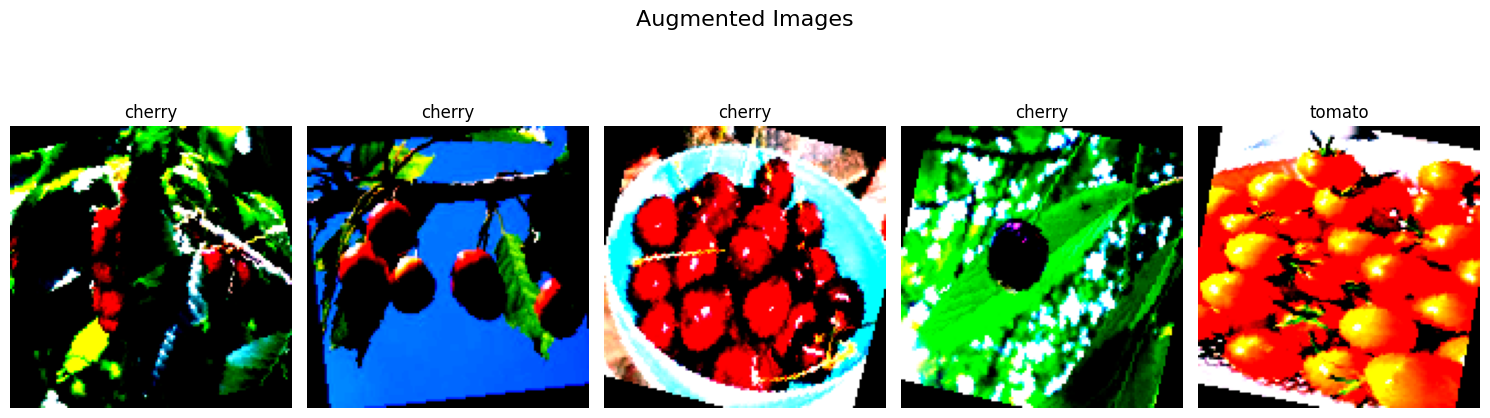

In [15]:
# Define augmentation transforms
transform_augmented = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
        transforms.RandomHorizontalFlip(p=0.5),  # New augmentation: Random horizontal flip
        transforms.RandomRotation(degrees=15),   # New augmentation: Random rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.Lambda(lambda x: x * torch.tensor([1.5, 0.9, 0.9]).view(3, 1, 1))

])

# Create augmented dataset
dataset_augmented = ImageFolder(root=data_dir, transform=transform_augmented)
data_loader_augmented = DataLoader(dataset_augmented, batch_size=5, shuffle=True)

# Get a batch of augmented images
images_aug, labels_aug = next(iter(data_loader_augmented))

# Show augmented images
show_images(images_aug, labels_aug, class_names, title="Augmented Images")
